## Project the Population Receptive Field into the visual field

In [1]:
# Import the necessary modules
import cortex
import cortex.polyutils
import sys
import numpy as np
import os
opj = os.path.join
from prfpy.fit import Iso2DGaussianFitter, Fitter, Extend_Iso2DGaussianFitter
import neuropythy
from neuropythy import as_retinotopy
from matplotlib import cm
import pickle
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d
import pandas as pd
from scipy.stats import pearsonr
import ast

In [2]:
# Set up the directories and parameters
subjectid='sub-02'
subject = subjectid
atlas = 'manual'
depth='GM'
project='PROJECT_EGRET-AAA'
denoising='nordic'
MAIN_PATH=f'/Volumes/FedericaCardillo/pre-processing/projects/{project}/derivatives'
model_name='nelder-mead'
space='fsnative'
roi=['all']
r2_thr=0.1 
fs_dirPATH=f'{MAIN_PATH}/freesurfer'
task = 'RET'
save_dir = "/Users/federicacardillo/Desktop/EGRET-AAA/pRFmapping/heatmap"
glaucoma = ['sub-02', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08','sub-09', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18', 'sub-19', 'sub-20', 'sub-48'] # Missing 08 and 19
controls = ['sub-21', 'sub-22', 'sub-23', 'sub-25', 'sub-26', 'sub-27', 'sub-28', 'sub-29', 'sub-30', 'sub-31', 'sub-32', 'sub-33', 'sub-34', 'sub-35', 'sub-36', 'sub-37', 'sub-38', 'sub-39', 'sub-40', 'sub-41', 'sub-42','sub-43', 'sub-44','sub-45','sub-46']

In [4]:
# Load the surface and vertices of the subject
surfs = [cortex.polyutils.Surface(*d) for d in cortex.db.get_surf(subject, "fiducial")]
numel_left = surfs[0].pts.shape[0]
numel_right = surfs[1].pts.shape[0]
numel = numel_left + numel_right

idx_rois1, idx_vls1 = cortex.freesurfer.get_label(subject, label='benson14_eccen-0001', fs_dir=fs_dirPATH, hemisphere=('lh', 'rh'), verbose=True)
idx_rois2, idx_vls2 = cortex.freesurfer.get_label(subject, label='benson14_angle-0001', fs_dir=fs_dirPATH, hemisphere=('lh', 'rh'), verbose=True)
idx_rois3, idx_vls3 = cortex.freesurfer.get_label(subject, label='benson14_sigma-0001', fs_dir=fs_dirPATH, hemisphere=('lh', 'rh'), verbose=True)
idx_rois4, idx_vls4 = cortex.freesurfer.get_label(subject, label='benson14_varea-0001', fs_dir=fs_dirPATH, hemisphere=('lh', 'rh'), verbose=True)
if atlas=='manual':
    idx_rois5, idx_vls5 = cortex.freesurfer.get_label(subject, label='manualdelin', fs_dir=fs_dirPATH, hemisphere=('lh','rh'), verbose=True)
    idx_vls4[idx_rois5]=idx_vls5
    
idx_vls2[numel_left:]=-idx_vls2[numel_left:]
data=(idx_vls2,idx_vls1)
data=as_retinotopy(data, output_style='standard')
idx_vls2=data[0][:]

# Load the pRF mapping parameters 
test_file=opj(f'{MAIN_PATH}/pRFM/{subject}/ses-02/{denoising}/', f'model-{atlas}-{model_name}-{depth}_desc-prf_params_{task}.pkl')
with open(test_file, 'rb') as input:
    pkl_data = pickle.load(input)
prf_params=pkl_data['model'].iterative_search_params
roi_verts=np.where(pkl_data['rois_mask']==1)
prf_params_vx=roi_verts[0]
gauss_fitter=pkl_data['model']
best_vx=np.where(gauss_fitter.iterative_search_params[:,-1]==gauss_fitter.iterative_search_params[:,-1].max())

looking for ['/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/sub-02/label/lh.benson14_eccen-0001.label', '/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/sub-02/label/rh.benson14_eccen-0001.label']
looking for ['/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/sub-02/label/lh.benson14_angle-0001.label', '/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/sub-02/label/rh.benson14_angle-0001.label']
looking for ['/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/sub-02/label/lh.benson14_sigma-0001.label', '/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/sub-02/label/rh.benson14_sigma-0001.label']
looking for ['/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/sub-02/label/lh.benson14_varea-0001.labe

In [ ]:
# Plot the pRF parameters into the visual field
# plt.figure(figsize=(6,6))
# plt.scatter(gauss_fitter.iterative_search_params[:,0], gauss_fitter.iterative_search_params[:,1],marker='o', s=2)
# plt.xlim(-7,7)
# plt.ylim(-7,7)
# plt.show()

# Plot with heatmap coloring based on sigma
plt.figure(figsize=(8,6))
color_bar = plt.scatter(gauss_fitter.iterative_search_params[:,0], gauss_fitter.iterative_search_params[:,1], marker='o', s=2, cmap='hot', c=gauss_fitter.iterative_search_params[:, 2])
plt.xlim(-7, 7)
plt.ylim(-7, 7)
plt.colorbar(color_bar, label='pRF size (σ)')
plt.grid(True)
plt.show()

### Heat map

In [ ]:
# Generate the heatmaps for the control gourp 
def heatmap_controls(controls, group_name, MAIN_PATH, atlas, model_name, depth, denoising, task):
    all_x = []
    all_y = []
    all_sigma = []
    statistics = []  

    for subj in controls:
        try:
            prf_file = os.path.join(MAIN_PATH, f'pRFM/{subj}/ses-02/{denoising}/model-{atlas}-{model_name}-{depth}_desc-prf_params_{task}.pkl')
            with open(prf_file, 'rb') as f:
                pkl = pickle.load(f)
            params = pkl['model'].iterative_search_params
            x = params[:, 0]
            y = params[:, 1]
            sigma = params[:, 2]
            all_x.append(x)
            all_y.append(y)
            all_sigma.append(sigma)
            stat, _, _, _ = binned_statistic_2d(x, y, sigma, statistic='mean', bins=70, range=[[-7, 7], [-7, 7]])
            statistics.append(stat)
        except FileNotFoundError:
            continue

    if all_x:
        x = np.concatenate(all_x)
        y = np.concatenate(all_y)
        sigma = np.concatenate(all_sigma)

        plt.figure(figsize=(8, 6))
        sc = plt.scatter(x, y, marker='o', s=2, cmap='hot', c=sigma)
        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.colorbar(sc, label='pRF size')
        plt.title(f'pRF heatmap: {group_name}')
        plt.grid(True)
        os.makedirs("/Users/federicacardillo/Desktop/EGRET-AAA/pRFmapping/heatmap", exist_ok=True)
        plt.savefig(os.path.join("/Users/federicacardillo/Desktop/EGRET-AAA/pRFmapping/heatmap", f"controls_{task}_raw.jpg"))
        plt.show()

        stat, x_edges, y_edges, binnumber = binned_statistic_2d(x, y, sigma, statistic='mean', bins=70, range=[[-7, 7], [-7, 7]])
        plt.figure(figsize=(8, 6))
        plt.imshow(stat.T, origin='lower', extent=[-7, 7, -7, 7], aspect='equal', cmap='hot')
        plt.colorbar(label='Mean pRF size')
        plt.title(f'pRF heatmap (binned): {group_name}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.grid(False)
        plt.savefig(os.path.join("/Users/federicacardillo/Desktop/EGRET-AAA/pRFmapping/heatmap", f"controls_{task}_bin.jpg"))
        plt.show()

        statistics = np.array(statistics)
        mean_map = np.nanmean(statistics, axis=0)
        std_map = np.nanstd(statistics, axis=0)
        return mean_map, std_map
    else:
        return None, None

def heatmap_glaucoma(subjects, group_name, MAIN_PATH, save_dir, atlas, model_name, depth, denoising, task, mean_map, std_map):
    glaucoma_maps = {} 
    zscore_maps = {}

    for subj in subjects:
        prf_file = os.path.join(MAIN_PATH, f'pRFM/{subj}/ses-02/{denoising}/model-{atlas}-{model_name}-{depth}_desc-prf_params_{task}.pkl')
        try:
            with open(prf_file, 'rb') as f:
                pkl = pickle.load(f)
            params = pkl['model'].iterative_search_params
            x = params[:, 0]
            y = params[:, 1]
            sigma = params[:, 2]

            # Compute binned heatmap
            stat, _, _, _ = binned_statistic_2d(x, y, sigma, statistic='mean', bins=70, range=[[-7, 7], [-7, 7]])
            glaucoma_maps[subj] = stat

            # Save the raw pRF map heatmap
            plt.figure(figsize=(8, 6))
            plt.imshow(stat.T, origin='lower', extent=[-7, 7, -7, 7], aspect='equal', cmap='hot')
            plt.colorbar(label='Mean pRF size')
            plt.title(f'{group_name}: {subj}')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.grid(False)
            plt.savefig(os.path.join(save_dir, f"{group_name.lower()}_{subj}_{task}_bin.jpg"))
            plt.close()

            # Compute and store z-score map
            with np.errstate(divide='ignore', invalid='ignore'):
                zmap = (stat - mean_map) / std_map
                zmap[np.isnan(zmap)] = 0
            zscore_maps[subj] = zmap

            # Save z-map visualization
            plt.figure(figsize=(8, 6))
            plt.imshow(zmap.T, origin='lower', extent=[-7, 7, -7, 7], aspect='equal', cmap='bwr', vmin=-3, vmax=3)
            plt.colorbar(label='Z-score deviation')
            plt.title(f'Z-score map: {subj}')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.grid(False)
            plt.savefig(os.path.join(save_dir, f"zmap_{subj}_{task}.jpg"))
            plt.close()

        except FileNotFoundError:
            print(f"File not found for {subj}")

    return glaucoma_maps, zscore_maps

In [ ]:
mean_map, std_map = heatmap_controls(controls, 'Controls', MAIN_PATH, atlas, model_name, depth, denoising, task)
glaucoma_maps, zscore_maps = heatmap_glaucoma(glaucoma, 'Glaucoma', MAIN_PATH, save_dir, atlas, model_name, depth, denoising, task, mean_map, std_map)

In [ ]:
## Add this to the main heatmap_glaucoma
def compute_quadrant_deviation_scores(zscore_maps, threshold=2):
    quadrant_scores = {}

    for subj, zmap in zscore_maps.items():
        abs_zmap = np.abs(zmap)

        # Quadrants
        UL = abs_zmap[35:70, 0:35]
        UR = abs_zmap[35:70, 35:70]
        DL = abs_zmap[0:35, 0:35]
        DR = abs_zmap[0:35, 35:70]
        # Count abnormal bins per quadrant
        quadrant_scores[subj] = {'UL': np.sum(UL > threshold), 'UR': np.sum(UR > threshold), 'DL': np.sum(DL > threshold), 'DR': np.sum(DR > threshold),}

    return quadrant_scores

quadrant_scores = compute_quadrant_deviation_scores(zscore_maps)

In [ ]:
# Load opththalmological data
ophth_excel_path = '/Users/federicacardillo/Desktop/EGRET-AAA/2025/OphthalmologicalTests/ophthtests.xlsx'
ophth_df = pd.read_excel(ophth_excel_path)
opth_quadrants = ['DX_RX_UL', 'DX_RX_UR', 'DX_RX_DL', 'DX_RX_DR']

# === Safe literal evaluation for list strings === ## THIS IS SOLVING THE DATAFRAM ERROR
def safe_literal_eval(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return np.nan
    return x

# === Parse and compute mean for each list in each quadrant ===
for opth_quadrant in opth_quadrants:
    ophth_df[opth_quadrant] = ophth_df[opth_quadrant].apply(safe_literal_eval)
    ophth_df[opth_quadrant] = ophth_df[opth_quadrant].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else np.nan)

# === Compute overall mean across all quadrants (optional) ===
ophth_df['Mean_Ophth'] = ophth_df[opth_quadrants].mean(axis=1)

# === Prepare quadrant-level Z-map deviation scores as DataFrame ===
quadrant_df = pd.DataFrame.from_dict(quadrant_scores, orient='index')
quadrant_df.index.name = 'Subject'
quadrant_df.reset_index(inplace=True)

# === Prepare and rename ophthalmological quadrant scores ===
ophth_quadrants = ophth_df[['Subject'] + opth_quadrants].copy()
ophth_quadrants.rename(columns={
    'DX_RX_UL': 'Ophth_UL',
    'DX_RX_UR': 'Ophth_UR',
    'DX_RX_DL': 'Ophth_DL',
    'DX_RX_DR': 'Ophth_DR'}, inplace=True)

# === Merge the two ===
merged_quadrant_df = pd.merge(quadrant_df, ophth_quadrants, on='Subject')
import scipy.stats
# === Correlate and plot each quadrant ===
for quad in ['UL', 'UR', 'DL', 'DR']:
    z_col = quad
    o_col = f'Ophth_{quad}'
    df = merged_quadrant_df.dropna(subset=[z_col, o_col])

    r, p = pearsonr(df[z_col], df[o_col])
    print(f"{quad}: Pearson r = {r:.2f}, p = {p:.3f}")
    a, b = scipy.stats.spearmanr(df[z_col], df[o_col])
    print(f"{quad}: Spearman r = {a:.2f}, p = {b:.3f}")

    # Plot correlation
    plt.figure()
    plt.scatter(df[o_col], df[z_col])
    plt.xlabel(f'Ophthalmological Score ({quad})')
    plt.ylabel(f'Z-map Deviation Score ({quad})')
    plt.title(f'{quad} Quadrant Correlation\nr = {r:.2f}, p = {p:.3f}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Coverage map

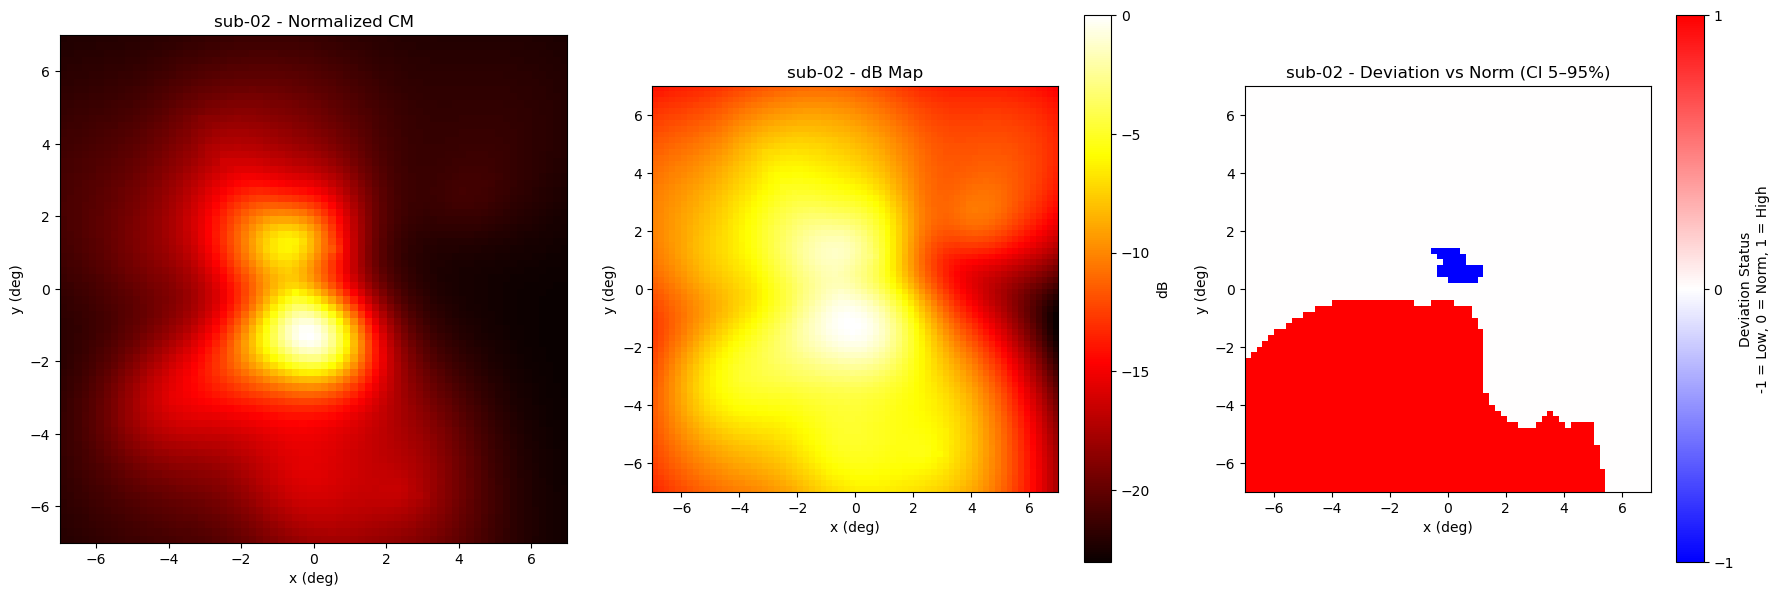

In [5]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

# --- CONFIGURABLE PARAMETERS ---
GRID_SIZE = 70
FOV = 7
VE_THRESHOLD = 0.15

# --- CORE UTILITIES ---

def create_voxel_cm(x, y, sigma, ve, grid_size=GRID_SIZE, fov=FOV):
    if ve < VE_THRESHOLD or sigma <= 0:
        return np.zeros((grid_size, grid_size))
    lin = np.linspace(-fov, fov, grid_size)
    xv, yv = np.meshgrid(lin, lin)
    gauss = np.exp(-((xv - x)**2 + (yv - y)**2) / (2 * sigma**2))
    return gauss * ve

def get_prf_indices_for_roi(roi_indices, prf_params_vx):
    return [i for i, vx in enumerate(prf_params_vx) if vx in roi_indices]

def generate_roi_cm(prf_params, roi_indices, grid_size=GRID_SIZE, fov=FOV):
    x, y, sigma, ve = prf_params[:, 0], prf_params[:, 1], prf_params[:, 2], prf_params[:, -1]
    cm = np.zeros((grid_size, grid_size))
    for i in roi_indices:
        cm += create_voxel_cm(x[i], y[i], sigma[i], ve[i], grid_size, fov)
    return cm

def compute_zmap(cm, norm_mean, norm_std):
    with np.errstate(divide='ignore', invalid='ignore'):
        z = (cm - norm_mean) / norm_std
        z[np.isnan(z)] = 0
    return z

def convert_to_db(cm_norm, min_val=1e-4):
    return 10 * np.log10(np.clip(cm_norm, min_val, 1))

# --- MAIN FUNCTION ---

def generate_cm(subject, MAIN_PATH, denoising, atlas, model_name, depth, task, roi_masks, normalize=True):
    try:
        file_path = os.path.join(
            MAIN_PATH, f'pRFM/{subject}/ses-02/{denoising}/',
            f'model-{atlas}-{model_name}-{depth}_desc-prf_params_{task}.pkl'
        )
        with open(file_path, 'rb') as input:
            data = pickle.load(input)

        prf_params = data['model'].iterative_search_params
        prf_params_vx = np.where(data['rois_mask'] == 1)[0]

        cm_all = np.zeros((GRID_SIZE, GRID_SIZE))
        for roi_key, roi_indices in roi_masks.items():
            relevant_indices = get_prf_indices_for_roi(roi_indices, prf_params_vx)
            cm_all += generate_roi_cm(prf_params, relevant_indices)

        if normalize and np.nanmax(cm_all) > 0:
            cm_all /= np.nanmax(cm_all)
        return cm_all

    except Exception as e:
        print(f"Error with {subject}: {e}")
        return None

# --- VISUALIZATION ---

def visualize_cm_results(subject, cm_norm, db_map, z_map, ci_5, ci_95, fov=FOV):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].imshow(cm_norm.T, origin='lower', cmap='hot', extent=[-fov, fov, -fov, fov])
    axs[0].set_title(f'{subject} - Normalized CM')
    axs[0].grid(False)

    im1 = axs[1].imshow(db_map.T, origin='lower', cmap='hot', extent=[-fov, fov, -fov, fov])
    axs[1].set_title(f'{subject} - dB Map')
    fig.colorbar(im1, ax=axs[1], label='dB')

    below = db_map < ci_5
    above = db_map > ci_95
    classified = np.zeros_like(db_map)
    classified[below] = -1
    classified[above] = 1

    im2 = axs[2].imshow(classified.T, origin='lower', cmap='bwr', extent=[-fov, fov, -fov, fov], vmin=-1, vmax=1)
    axs[2].set_title(f'{subject} - Deviation vs Norm (CI 5–95%)')
    fig.colorbar(im2, ax=axs[2], ticks=[-1, 0, 1], label='Deviation Status\n-1 = Low, 0 = Norm, 1 = High')

    for ax in axs:
        ax.set_xlabel('x (deg)')
        ax.set_ylabel('y (deg)')

    plt.tight_layout()
    plt.show()

# --- NORMATIVE MODEL BUILDER ---

def build_normative_model(controls, MAIN_PATH, denoising, atlas, model_name, depth, task, roi_masks):
    cms = []
    for subj in controls:
        cm = generate_cm(subj, MAIN_PATH, denoising, atlas, model_name, depth, task, roi_masks)
        if cm is not None:
            cms.append(cm)
    cms = np.array(cms)
    return cms, np.nanmean(cms, axis=0), np.nanstd(cms, axis=0)

def compute_confidence_intervals(control_cms, percentiles=[5, 95]):
    dbs = [convert_to_db(cm) for cm in control_cms]
    dbs = np.stack(dbs)
    return {
        f'{p}%': np.percentile(dbs, p, axis=0)
        for p in percentiles
    }

# --- USAGE EXAMPLE ---
# Fill in these variables before running:
subject = 'sub-02'
varea_labels = {1: 'V1', 2: 'V2', 3: 'V3'}
roi_masks = {}

for roi_val, roi_name in varea_labels.items():
    roi_masks[f'lh_{roi_name}'] = np.where((idx_vls4[:numel_left] == roi_val))[0]
    roi_masks[f'rh_{roi_name}'] = np.where((idx_vls4[numel_left:] == roi_val))[0] + numel_left

control_cms, normative_map, normative_std = build_normative_model(controls, MAIN_PATH, denoising, atlas, model_name, depth, task, roi_masks)
subject_cm = generate_cm(subject, MAIN_PATH, denoising, atlas, model_name, depth, task, roi_masks)
subject_db = convert_to_db(subject_cm)
subject_z = compute_zmap(subject_cm, normative_map, normative_std)
ci_maps = compute_confidence_intervals(control_cms)
visualize_cm_results(subject, subject_cm, subject_db, subject_z, ci_maps['5%'], ci_maps['95%'])